# Chargement des librairies

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Input, Model
from keras.layers import Dense, Dropout, UpSampling2D, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, Add, Multiply, Reshape, Dot
from keras.layers import LSTM

from keras.datasets import mnist

import numpy as np
import os, shutil, sys
import imageio
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import statistics
import datetime
import time
import spectral.io.envi as envi
import imageio
import urllib.request, json

from keras.callbacks import TensorBoard

from sklearn.svm import SVC

Using TensorFlow backend.


# Chargement de la base de donnée - Donnée d'entrainement

In [2]:
path_data="dataset1/images_prepped_train/"
path_GT="dataset1/annotations_prepped_train/"

list_img_train=os.listdir(path_data)
list_GT_train=os.listdir(path_GT)

N=len(list_img_train)
img0=imageio.imread(path_data+list_img_train[0])
I=img0.shape[0]
J=img0.shape[1]
L=img0.shape[2]

X=np.zeros((N,I,J,L))
Y=np.zeros((N,I,J,1))

c_min=1
c_max=0

for n in range(N):
    img_t=imageio.imread(path_data+list_img_train[n])
    GT_t=imageio.imread(path_GT+list_img_train[n])
    
    X[n,:,:,:]=img_t
    Y[n,:,:,0]=GT_t
    
    c_min=min(c_min,np.min(GT_t))
    c_max=max(c_max,np.max(GT_t))

    
num_classes=c_max-c_min+1
    

f=10
    
N0=int(f*f*N)
I0=int(I/f)
J0=int(J/f)

X_red=np.zeros((N0,I0,J0,L))
Y_red=np.zeros((N0,I0,J0,1))

n0=0
for n in range(N):
    i0=0    
    i1=i0+I0
    
    #plt.imshow(X[n,:,:,:]/255.0)
    #plt.show()
    
    while(i1<=I):
        j0=0
        j1=j0+J0
        while(j1<=J):
            X_red[n0,:,:,:]=X[n,i0:i1,j0:j1,:]/255.0            
            Y_red[n0,:,:,0]=Y[n,i0:i1,j0:j1,0]
            
            #plt.imshow(X_red[n0,:,:,:])
            #plt.show()            
            #plt.imshow(Y_red[n0,:,:,0])
            #plt.show()
            
            n0+=1
            j0+=J0
            j1+=J0
        i0+=I0
        i1+=I0

# Modèle

In [3]:
NFeat=20
FConv=64
FDConv=128

I1=Input(shape=(None,None,L),name="Input")

Conv01=Conv2D(FConv, (3, 3), padding='same',name="CLayer1",activation="relu")(I1)
Conv02=Conv2D(FConv, (3, 3), padding='same',name="CLayer2",activation="relu")(Conv01)
MaxPool01=MaxPooling2D(pool_size=(2, 2))(Conv02)

Conv03=Conv2D(FConv, (3, 3), padding='same',name="CLayer3",activation="relu")(MaxPool01)
Conv04=Conv2D(FConv, (3, 3), padding='same',name="CLayer4",activation="relu")(Conv03)
MaxPool02=MaxPooling2D(pool_size=(2, 2))(Conv04)

Conv05=Conv2D(FConv, (3, 3), padding='same',name="CLayer5",activation="relu")(MaxPool02)
Conv06=Conv2D(FConv, (3, 3), padding='same',name="CLayer6",activation="relu")(Conv05)

DConv1=Conv2DTranspose(FDConv, (3, 3), strides=(2, 2), padding='same',name="DCLayer1",activation="relu")(Conv06)
Conv07=Conv2D(FConv, (3, 3), padding='same',name="CLayer7",activation="relu")(DConv1)
Conv08=Conv2D(FConv, (3, 3), padding='same',name="CLayer8",activation="relu")(Conv07)

DConv2=Conv2DTranspose(FDConv, (3, 3), strides=(2, 2), padding='same',name="DCLayer2",activation="relu")(Conv08)
Conv09=Conv2D(FConv, (3, 3), padding='same',name="CLayer9",activation="relu")(DConv2)
Conv10=Conv2D(FConv, (3, 3), padding='same',name="CLayer10",activation="relu")(Conv09)

O2=Conv2D(NFeat, (3, 3), padding='same',name="Output2")(Conv10)
O2a=Activation("relu")(O2)

O1=Conv2D(num_classes, (3, 3), padding='same',name="Output1")(O2a)
O1a=Activation("softmax")(O1)

model=Sequential()
model=Model(inputs=[I1], outputs=[O1a])

model_feature=Sequential()
model_feature=Model(inputs=[I1], outputs=[O2])

# initiate RMSprop optimizer
opt=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

losses=["categorical_crossentropy"]
employed_metrics=["mae","mse","accuracy"]
employed_weights=[1.0]
model.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

losses=["mse"]
employed_metrics=["mae","accuracy"]
employed_weights=[1.0]
model_feature.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

print("Modèle de classification: ")
model.summary()
trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
print("Total params: "+str(trainable_count + non_trainable_count))
print("Trainable params: "+str(trainable_count))
print("Non-trainable params: "+str(non_trainable_count))

print("_________________________________________________________________")
print("_________________________________________________________________")
print("_________________________________________________________________")

print("Modèle d'extraction d'attributs: ")
model_feature.summary()
trainable_count = int(np.sum([K.count_params(p) for p in set(model_feature.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model_feature.non_trainable_weights)]))
print("Total params: "+str(trainable_count + non_trainable_count))
print("Trainable params: "+str(trainable_count))
print("Non-trainable params: "+str(non_trainable_count))

Modèle de classification: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None, None, 3)     0         
_________________________________________________________________
CLayer1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
CLayer2 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
CLayer3 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
CLayer4 (Conv2D)             (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 6

# Entrainement du modèle

In [4]:
batch_size=100
epochs=500

Y_class=keras.utils.to_categorical(Y_red, num_classes=num_classes)

tensorboard = TensorBoard(log_dir='./logs_semantic', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True,
                          write_images=True)

#model.fit([X_red],[Y_class],batch_size=batch_size,epochs=epochs, verbose=1, validation_split=0.2,callbacks=[tensorboard])

#model.save("model_semantic_seg.h5")
#model_feature.save("model_semantic_seg_feature.h5")

Instructions for updating:
Use the retry module or similar alternatives.


# Chargement de la base de donnée - Test

In [5]:
model=load_model("model_semantic_seg.h5")

path_data_test="dataset1/images_prepped_test/"
path_GT_test="dataset1/annotations_prepped_test/"

list_img_test=os.listdir(path_data_test)
list_GT_test=os.listdir(path_GT_test)

N=len(list_img_test)

img1=imageio.imread(path_data_test+list_img_test[0])
I=img0.shape[0]
J=img0.shape[1]
L=img0.shape[2]

X_test=np.zeros((N,I,J,L))
Y_test=np.zeros((N,I,J,1))
for n in range(N):
    img_t=imageio.imread(path_data+list_img_train[n])
    GT_t=imageio.imread(path_GT+list_img_train[n])
    
    X_test[n,:,:,:]=img_t
    Y_test[n,:,:,0]=GT_t

f1=5
    
N1=int(f1*f1*N)
I1=int(I/f1)
J1=int(J/f1)

X_test_red=np.zeros((N1,I1,J1,L))
Y_test_red=np.zeros((N1,I1,J1,1))

n0=0
for n in range(N):
    i0=0    
    i1=i0+I1
    
    #plt.imshow(X[n,:,:,:]/255.0)
    #plt.show()
    
    while(i1<=I):
        j0=0
        j1=j0+J1
        while(j1<=J):
            X_test_red[n0,:,:,:]=X_test[n,i0:i1,j0:j1,:]/255.0            
            Y_test_red[n0,:,:,0]=Y_test[n,i0:i1,j0:j1,0]
            
            #plt.imshow(X_red[n0,:,:,:])
            #plt.show()            
            #plt.imshow(Y_red[n0,:,:,0])
            #plt.show()
            
            n0+=1
            j0+=J1
            j1+=J1
        i0+=I1
        i1+=I1
    
Y_test_class=keras.utils.to_categorical(Y_test_red, num_classes=num_classes)


loss_and_metrics = model.evaluate([X_test_red], [Y_test_class], batch_size=batch_size)

Y_p_red=model.predict([X_test_red], batch_size=batch_size)

print(loss_and_metrics)
    

2525/2525 [==============================] - 5s 2ms/step
[0.2708581771590922, 0.021007034245251428, 0.010881715140646637, 0.9088714748325915]


# Résultats de classification du modèle

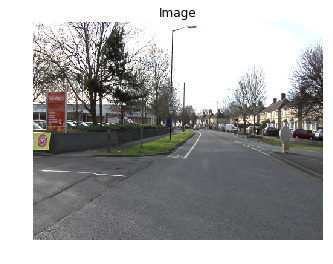

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


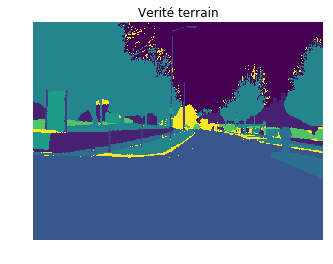

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 11.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


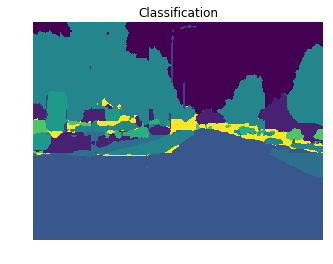

In [6]:
id_sample=99

img_in=np.zeros((I,J,L))
Y_p=np.zeros((I,J,num_classes))
img_out=np.zeros((I,J))
img_GT=np.zeros((I,J))

n0=int(id_sample*f1*f1)



i0=0    
i1=i0+I1
while(i1<=I):
    j0=0
    j1=j0+J1
    while(j1<=J):
        
        Y_p[i0:i1,j0:j1,:]=Y_p_red[n0,:,:,:]
        
        n0+=1
        
        j0+=J1
        j1+=J1
    i0+=I1
    i1+=I1

for i in range(I):
    for j in range(J):
        img_in[i,j,:]=X_test[id_sample,i,j,:]/255.0
        img_out[i,j]=np.argmax(Y_p[i,j,:])
        img_GT[i,j]=Y_test[id_sample,i,j,0]



plt.imshow(img_in)
plt.axis('off')
plt.title('Image')
plt.show()
imageio.imwrite("image.png",img_in)

plt.imshow(img_GT)
plt.axis('off')
plt.title('Verité terrain')
plt.show()
imageio.imwrite("GT.png",img_GT)

plt.imshow(img_out)
plt.axis('off')
plt.title('Classification')
plt.show()
imageio.imwrite("Classif.png",img_out)

/homes/c18deche/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


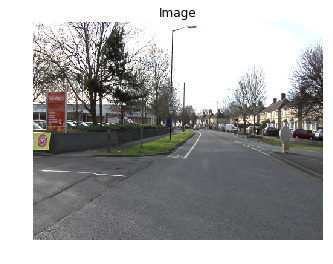

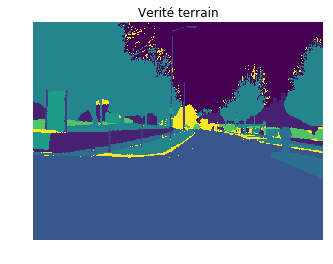

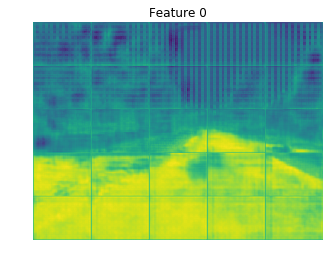

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.512547492980957, 3.787076234817505]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


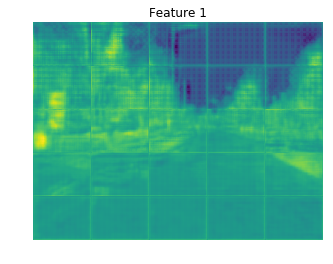

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.542876243591309, 4.744143486022949]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


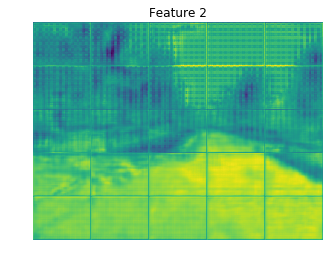

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.4731502532958984, 3.4374961853027344]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


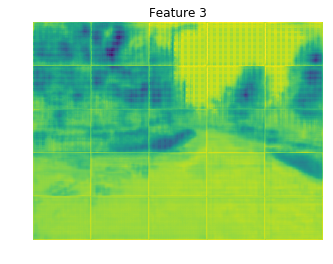

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10.144207000732422, 2.9259653091430664]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


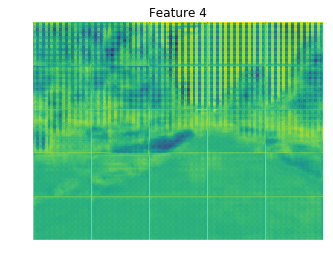

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.784799337387085, 0.4438672959804535]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


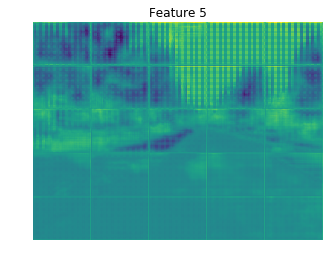

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.706809043884277, 3.808729648590088]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


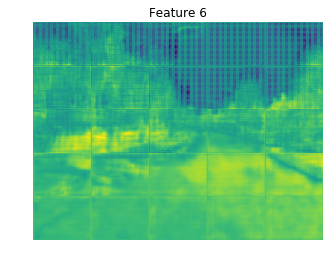

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.450599193572998, 4.187926292419434]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


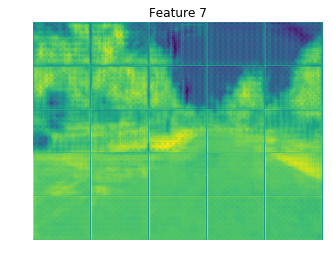

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.589269161224365, 1.5587064027786255]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


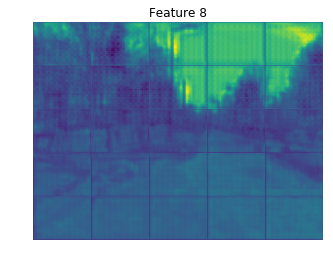

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.9899598360061646, 11.486810684204102]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


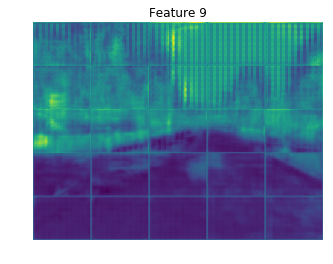

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.3845489025115967, 7.632528781890869]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


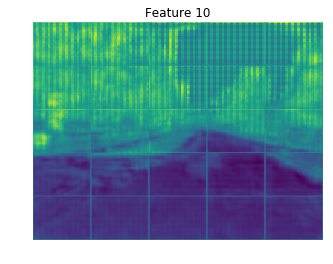

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.2837514877319336, 5.183724403381348]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


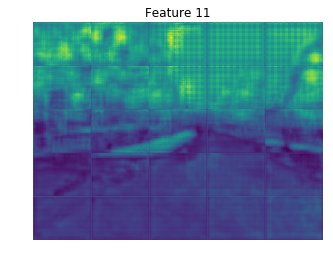

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.502270221710205, 6.752040386199951]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


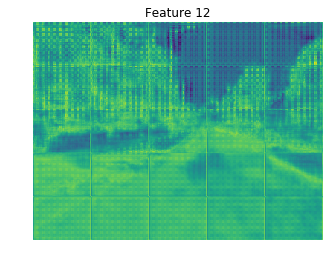

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.1029651165008545, 0.3078731894493103]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


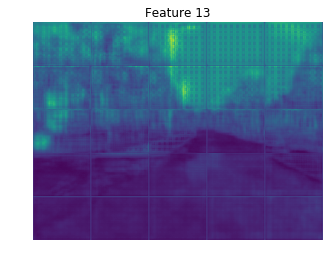

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.498833179473877, 8.953485488891602]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


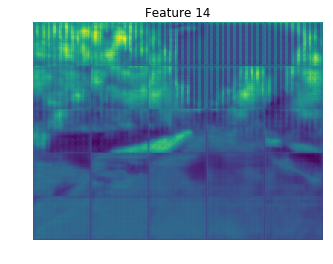

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.5748424530029297, 7.8075127601623535]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


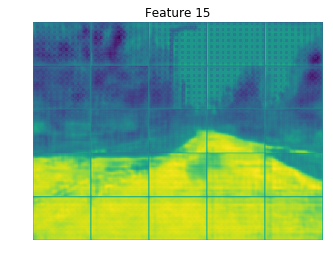

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.5870280265808105, 5.67465877532959]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


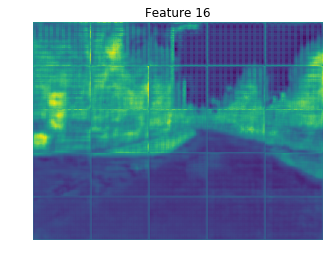

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.5975253582000732, 6.112881660461426]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


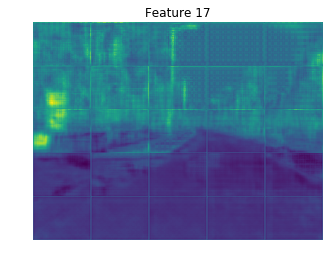

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.3492894172668457, 4.6529622077941895]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


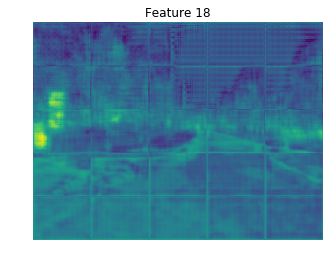

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.61997389793396, 6.206094741821289]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


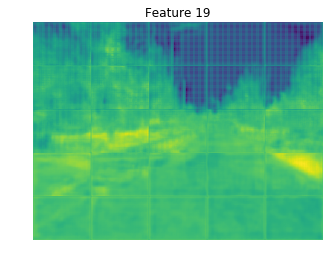

/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-11.933042526245117, 7.04892635345459]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [12]:
model_feature=load_model("model_semantic_seg_feature.h5")

path_data_test="dataset1/images_prepped_test/"
path_GT_test="dataset1/annotations_prepped_test/"

list_img_test=os.listdir(path_data_test)
list_GT_test=os.listdir(path_GT_test)

N=len(list_img_test)

img1=imageio.imread(path_data_test+list_img_test[0])
I=img0.shape[0]
J=img0.shape[1]
L=img0.shape[2]

X_test=np.zeros((N,I,J,L))
Y_test=np.zeros((N,I,J,1))
for n in range(N):
    img_t=imageio.imread(path_data+list_img_train[n])
    GT_t=imageio.imread(path_GT+list_img_train[n])
    
    X_test[n,:,:,:]=img_t
    Y_test[n,:,:,0]=GT_t

f1=5
    
N1=int(f1*f1*N)
I1=int(I/f1)
J1=int(J/f1)

X_test_red=np.zeros((N1,I1,J1,L))
Y_test_red=np.zeros((N1,I1,J1,1))

n0=0
for n in range(N):
    i0=0    
    i1=i0+I1
    
    #plt.imshow(X[n,:,:,:]/255.0)
    #plt.show()
    
    while(i1<=I):
        j0=0
        j1=j0+J1
        while(j1<=J):
            X_test_red[n0,:,:,:]=X_test[n,i0:i1,j0:j1,:]/255.0            
            Y_test_red[n0,:,:,0]=Y_test[n,i0:i1,j0:j1,0]
            
            #plt.imshow(X_red[n0,:,:,:])
            #plt.show()            
            #plt.imshow(Y_red[n0,:,:,0])
            #plt.show()
            
            n0+=1
            j0+=J1
            j1+=J1
        i0+=I1
        i1+=I1
    
Y_test_class=keras.utils.to_categorical(Y_test_red, num_classes=num_classes)

#loss_and_metrics = model_feature.evaluate([X_test_red], [Y_test_class], batch_size=batch_size)

feature=model_feature.predict([X_test_red], batch_size=batch_size)

id_sample=99

img_in=np.zeros((I,J,L))
Y_p=np.zeros((I,J,NFeat))
img_out=np.zeros((I,J,NFeat))
img_GT=np.zeros((I,J))

n0=int(id_sample*f1*f1)



i0=0    
i1=i0+I1
while(i1<=I):
    j0=0
    j1=j0+J1
    while(j1<=J):

        Y_p[i0:i1,j0:j1,:]=feature[n0,:,:,:]
        
        n0+=1
        
        j0+=J1
        j1+=J1
    i0+=I1
    i1+=I1

for i in range(I):
    for j in range(J):
        img_in[i,j,:]=X_test[id_sample,i,j,:]/255.0
        img_out[i,j]=Y_p[i,j,:]
        img_GT[i,j]=Y_test[id_sample,i,j,0]

        
plt.imshow(img_in)
plt.axis('off')
plt.title('Image')
plt.show()

plt.imshow(img_GT)
plt.axis('off')
plt.title('Verité terrain')
plt.show()

for n in range(NFeat):
    plt.imshow(img_out[:,:,n])
    plt.axis('off')
    plt.title('Feature '+str(n))
    plt.show()
    
    imageio.imwrite("feature"+str(n)+".png",img_out[:,:,n])